In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os


In [3]:
penguins = pd.read_csv('./datasets/penguins.csv')
penguins = penguins.dropna()
penguins = penguins.drop(['year'],axis=1)

In [4]:
#categorical encoding
penguins = pd.get_dummies(penguins, columns=['species', 'island', 'sex'], drop_first=True)

In [5]:
#normalization
columns_to_normalize = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
for column in columns_to_normalize:
    penguins[column] = (penguins[column] - min(penguins[column]))/max(penguins[column])

In [6]:
#train test split
X = penguins.drop('sex_male', axis=1)
X.insert(0,"bias", 1)
y = penguins['sex_male']
size = len(X)
train_size = int(.8 * size)
x_train, x_test, y_train, y_test = X[0: train_size], X[train_size:], y[0:train_size], y[train_size:]


/var/folders/_7/dv55sgcd0bs_g41db7fwfwsw0000gn/T/ipykernel_28489/1228423878.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x_train, x_test, y_train, y_test = X[0: train_size], X[train_size:], y[0:train_size], y[train_size:]


In [7]:
class LogitRegression:
    learning_rate = 0.1
    num_iterations = 10000
    weights = np.random.uniform(low=0, high=1,size = 0)

    def initialize(self, learning_rate, num_iterations):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def __init__(self, learning_rate, num_iterations):
        self.initialize(learning_rate, num_iterations)
    
    def sigmoid(self,z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        return self.sigmoid(np.dot(X, self.weights))

    def cost_function(self,X, Y):
        h = self.predict(X)
        return (-1/len(Y)) * np.sum(Y * np.log(h) + (1 - Y) * np.log(1 - h))

    def gradient_descent(self,X, Y):
        h = self.predict(X)

        self.weights = self.weights - (self.learning_rate/len(Y)) * np.dot(X.T, (h - Y))
        return self.weights, self.cost_function(X,Y)

    def score(self,x_test,y_test):
        y_pred = [1 if (self.predict(row) >= 0.5) else 0 for (ind,row) in x_test.iterrows()]
        count = 0
        for (p,t) in zip(y_pred, y_test):
            if p == t:
                count = count + 1
        
        return count/len(y_pred)

    def fit(self,X_train,Y_train):
        loss_list = []
        columns_count = X_train.shape[1]
        self.weights = np.zeros(columns_count)
        for i in range(self.num_iterations):
            self.weights, loss = self.gradient_descent(X_train, Y_train)
            print('learning rate : {0}, iteration : {1}, loss : {2}'.format(self.learning_rate, i, loss))
            loss_list.append(loss)
        return self.weights, loss_list


In [7]:
alpha = [0.001, 0.01, 0.05,0.02, 0.002, 0.025, 0.1]
num_iterations = [1000, 5000, 10000]

In [8]:
dir_name = './pickles/'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
for it in num_iterations:
    if not os.path.exists(dir_name + str(it) + '/'):
        os.mkdir(dir_name + str(it) + '/')

In [9]:
def dump_to_pickle(file_name, data):
    if os.path.exists(file_name):
        os.remove(file_name)
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
    f.close()
def read_from_pickle(file_path):
    with open(file_path,'rb') as pkl_file:
        pkl_data = pickle.load(pkl_file)
        
    return pkl_data

In [10]:

model = LogitRegression(0.1,1000)
df_list = []

for it in num_iterations:
    iterations_list = np.arange(0,it,1)
    for alph in alpha:
        model.initialize(alph,it)
        weights, loss_list =  model.fit(x_train,y_train)

        file_name = './pickles/' + str(it) + '/pickle_'+str(it)+'_'+str(alph)+'.pkl'
        dump_to_pickle(file_name, loss_list)
        
        score = model.score(x_test, y_test)
        df_list.append({
            'Learning Rate' : alph,
            'Iterations' : it,
            'Accuracy' : score
        })
df = pd.DataFrame.from_records(df_list)

learning rate : 0.001, iteration : 0, loss : 0.6931455786607915
learning rate : 0.001, iteration : 1, loss : 0.6931439770054845
learning rate : 0.001, iteration : 2, loss : 0.6931423755938529
learning rate : 0.001, iteration : 3, loss : 0.6931407744257266
learning rate : 0.001, iteration : 4, loss : 0.6931391735009349
learning rate : 0.001, iteration : 5, loss : 0.6931375728193077
learning rate : 0.001, iteration : 6, loss : 0.6931359723806744
learning rate : 0.001, iteration : 7, loss : 0.6931343721848651
learning rate : 0.001, iteration : 8, loss : 0.6931327722317098
learning rate : 0.001, iteration : 9, loss : 0.6931311725210386
learning rate : 0.001, iteration : 10, loss : 0.693129573052682
learning rate : 0.001, iteration : 11, loss : 0.6931279738264702
learning rate : 0.001, iteration : 12, loss : 0.6931263748422337
learning rate : 0.001, iteration : 13, loss : 0.6931247760998032
learning rate : 0.001, iteration : 14, loss : 0.6931231775990093
learning rate : 0.001, iteration : 1

In [11]:
df

Learning Rate  Iterations  Accuracy
0           0.001        1000  0.507463
1           0.010        1000  0.626866
2           0.050        1000  0.850746
3           0.020        1000  0.791045
4           0.002        1000  0.507463
5           0.025        1000  0.805970
6           0.100        1000  0.880597
7           0.001        5000  0.537313
8           0.010        5000  0.850746
9           0.050        5000  0.880597
10          0.020        5000  0.880597
11          0.002        5000  0.626866
12          0.025        5000  0.880597
13          0.100        5000  0.865672
14          0.001       10000  0.626866
15          0.010       10000  0.880597
16          0.050       10000  0.865672
17          0.020       10000  0.880597
18          0.002       10000  0.791045
19          0.025       10000  0.880597
20          0.100       10000  0.865672

In [12]:
df = df.sort_values(by=['Accuracy'], ascending=False)
df


Learning Rate  Iterations  Accuracy
10          0.020        5000  0.880597
9           0.050        5000  0.880597
19          0.025       10000  0.880597
17          0.020       10000  0.880597
15          0.010       10000  0.880597
6           0.100        1000  0.880597
12          0.025        5000  0.880597
16          0.050       10000  0.865672
13          0.100        5000  0.865672
20          0.100       10000  0.865672
8           0.010        5000  0.850746
2           0.050        1000  0.850746
5           0.025        1000  0.805970
3           0.020        1000  0.791045
18          0.002       10000  0.791045
1           0.010        1000  0.626866
11          0.002        5000  0.626866
14          0.001       10000  0.626866
7           0.001        5000  0.537313
4           0.002        1000  0.507463
0           0.001        1000  0.507463

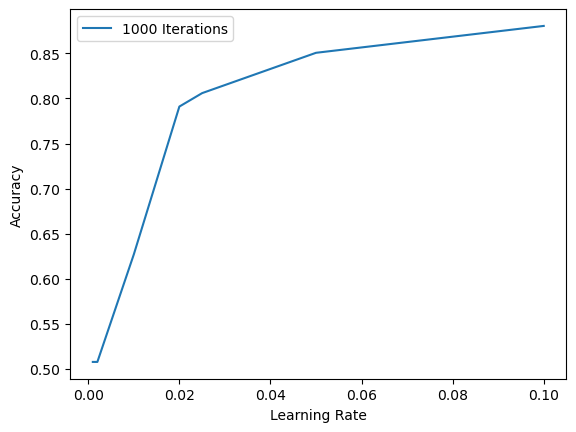

In [13]:
def accuracy_plot(col,iteration):
    df_filter = df[df[col] == iteration]
    learning_rate_vals = df_filter['Learning Rate']
    accuracy_vals = df_filter['Accuracy']

    plt.plot(learning_rate_vals, accuracy_vals, label=str(iteration)+' Iterations')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
accuracy_plot('Iterations',1000)

In [14]:
# take fixed iterations
target_folder = 5000
def plot_max_iter(target_folder):
    dir_to_plot = './pickles/' + str(target_folder) + '/'

    files_list = os.listdir(dir_to_plot)

    x_data = np.arange(0, target_folder, 1)
    for file_name in files_list:
        learning_rate = file_name
        pkl_data =  read_from_pickle(dir_to_plot + file_name)
        plt.plot(x_data, pkl_data, label=str(learning_rate))
        plt.title("Iterations vs Loss Function")
    plt.xlabel("Iterations")
    plt.legend()
    plt.show()

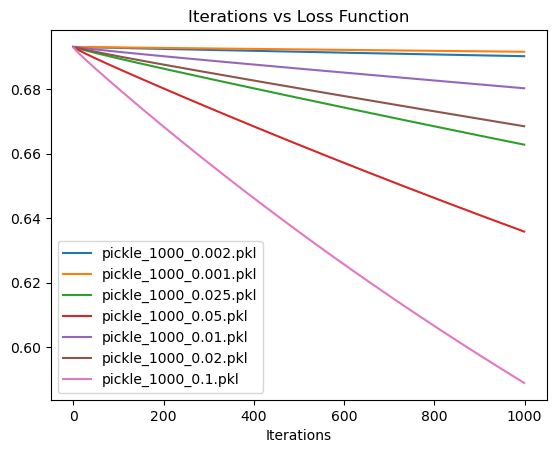

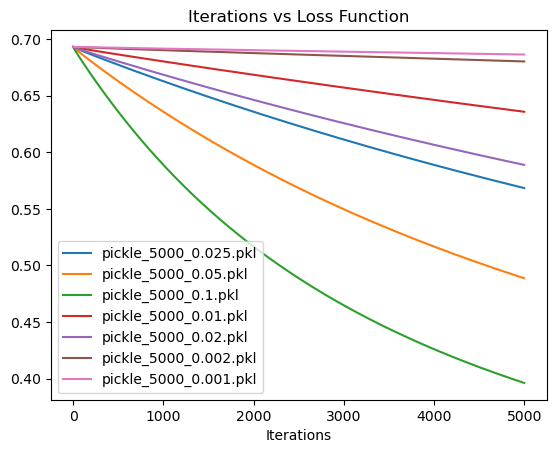

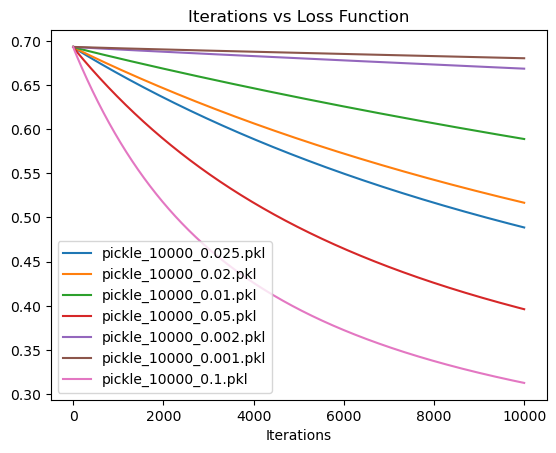

In [15]:

for iterations in num_iterations:
    plot_max_iter(iterations)